# General
In contrasts involving the surprise condition (Surprise>Magic and Surprise>Control) we found significant voxels in white matter and CSF

# Potential Solutions
Significant results in WM/CSF can be a sign of motion

## Increase in Motion parameters
The first attempt was to add the derivative, square and square of derivative of the six movement parameters as regressors 
This resulted in a decrease of significant voxels in CSF and WM, however did not solve the problem

## CSF, WM and GS as regressors
The next step was to add the mean WM and CSF signal as well as global signal and even the derivative, squares and derivatives of squares of CSF and WM to the GLM
All attempts only decreased the number of significant voxels, but did not resolve the whole problem

# Steps in this notebook
One step back from adding more regressors is to see if motion can really account for the artifact we found. We therefore
- correlate the SPM design matrix with framewise displacement (Power et al 2012)<br>
    did not reveal a systematically higher correlation between surprise and FD
- inspect variance in brain signal for the time of conditions

In [1]:
# import libraries
import os
import sys
import numpy as np
from scipy import stats
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import nilearn
from nilearn.image import load_img, new_img_like
from nilearn import plotting
from nilearn import surface
import nibabel as nib
import glob
from pathlib import Path
import re
import readmat

/gpfs01/bartels/user/vplikat/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/gpfs01/bartels/user/vplikat/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [107]:
HOME_DIR = str(Path.home())
PROJ_DIR = os.path.join(HOME_DIR,'Documents','Magic_fMRI','DATA','MRI')
RAWDATA_DIR = os.path.join(PROJ_DIR, 'rawdata')
FMRIPREP_DIR = os.path.join(PROJ_DIR, 'derivatives', 'fmriprep-21.0.1')
REALIGNED_DATA = os.path.join(PROJ_DIR,'derivatives','spm12','spm12-preproc','realigned')
RESULTS_DIR_6MP = os.path.join(PROJ_DIR,'derivatives','spm12','spm12-fla','WholeBrain',
                               'VideoTypes','6mm-smoothed-mnispace','SpecialMoment')
# get all subjects 
all_subjects = glob.glob(os.path.join(RAWDATA_DIR,'sub-*'))
all_subjects.sort()
subjects = [os.path.basename(sub) for sub in all_subjects]

### Calculate correlations between framewise displacement and condition

In [102]:
all_sub_dicts = []

for sub in subjects:
    # create empty dictionary for the correlations
    sub_dict = {'Magic': [], 'Surprise':[], 'Control':[]}
    
    # create empty list to store all the frame displacements in
    total_frame_displacement = []
    
    # read in the subject's SPM.mat file 
    current_SPM = readmat.load(os.path.join(RESULTS_DIR_6MP,sub,'SPM.mat'),isStruct=True)['SPM']['xX']
    # create a large dataframe for the design matrix
    spm_df = pd.DataFrame(data=np.array(current_SPM['X']),columns=current_SPM['name'])
    
    # get all realignment files
    realignmentfiles = glob.glob(os.path.join(REALIGNED_DATA, sub, 'func', 'rp_'+sub+'*.txt'))
    realignmentfiles.sort()
    
    # read in the realignment files 
    for realignf in realignmentfiles:
        # since MATLAB writes the realignment files in a strange way, we need to read them line by line
        with open(realignf,'r') as rf:
            realign_params = []
            for line in rf: # read lines
                realign_params.append([float(x) for x in line.split()])
        # initiate the framwise displacement for current run with 0 for the first entry
        run_fwd = [0] 
        # iterate over parameters and subtract parameter i-(i-1)
        for params, params_plus1 in zip(realign_params[:-1],realign_params[1:]):
            # spm returns the rotation parameters in rad
            # rad to transformation = rad * r (r = 50mm - Power et al 2012)
            delta = abs(np.array(params_plus1)-np.array(params))
            delta[3:]*=50
            run_fwd.append(sum(delta))
    
        total_frame_displacement.append(run_fwd)
        
    for condition in sub_dict.keys():
        run_correlations = []
        for i, (idx, cond_in_run) in enumerate(spm_df.filter(regex=condition).iteritems()):
            try:
                run_displacement = np.array(total_frame_displacement[i])
                run_design = cond_in_run.values[i*193:(i+1)*193]
                #[corr, p] = stats.spearmanr(run_displacement,run_design, nan_policy='omit')
                [corr, p] = stats.pearsonr(run_displacement,run_design)
                run_correlations.append(corr)
            except:
                print('Tada')
        sub_dict[condition].append(np.abs(np.arctanh(run_correlations)).mean())
    all_sub_dicts.append(sub_dict)

Tada
Tada
Tada


#### Test and plot differences in correlation

In [103]:
mag_corr = [abs(all_sub_dicts[s]['Magic'][0]) for s in range(len(all_sub_dicts))]
sur_corr = [abs(all_sub_dicts[s]['Surprise'][0]) for s in range(len(all_sub_dicts))]
con_corr = [abs(all_sub_dicts[s]['Control'][0]) for s in range(len(all_sub_dicts))]
t1 = pg.ttest(mag_corr, sur_corr,paired=True)
t2 = pg.ttest(mag_corr, con_corr,paired=True)
t3 = pg.ttest(con_corr, sur_corr,paired=True)

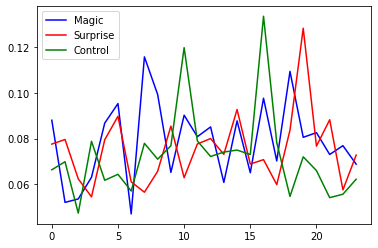

In [96]:
fig = plt.figure()
plt.plot(mag_corr,'b',label='Magic')
plt.plot(sur_corr,'r',label='Surprise')
plt.plot(con_corr,'g',label='Control')
plt.legend();

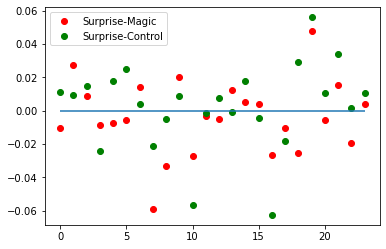

In [97]:
fig = plt.figure()
#plt.plot(,'b',label='Magic')
plt.plot(np.array(sur_corr)-np.array(mag_corr),'ro',label='Surprise-Magic')
plt.plot(np.array(sur_corr)-np.array(con_corr),'go',label='Surprise-Control')
plt.hlines(y=0,xmin=0,xmax=23)
plt.legend();

### Variance of signal in condition trials

In [122]:
sub = 'sub-02'
run = 3

eventfile = os.path.join(RAWDATA_DIR, sub, 'func', sub+'_task-magic_run-{:02}_events.tsv'.format(run))
confoundfile = os.path.join(FMRIPREP_DIR, sub, 'func',
                            sub+'_task-magic_run-{}_desc-confounds_timeseries.tsv'.format(run))

event_df = pd.read_csv(eventfile,sep='\t')
surprise_events = event_df[event_df.trial_type.str.contains('Surprise')]
magic_events = event_df[event_df.trial_type.str.contains('Magic')]
control_events = event_df[event_df.trial_type.str.contains('Control')]
confound_df = pd.read_csv(confoundfile,sep='\t')
confound_df['timestamps']=confound_df.index*TR

# extend confound_df with a column containing [0,1] for either it had surprise condition or not
# use new column to convolve with HDRF
confound_df['is_surprise'] = np.zeros((len(confound_df),1))
confound_df['is_magic'] = np.zeros((len(confound_df),1))
confound_df['is_control'] = np.zeros((len(confound_df),1))

for idx,surp in surprise_events.iterrows():
    confound_df.is_surprise = np.where((confound_df.timestamps>surp.onset) & (confound_df.timestamps<surp.onset+surp.duration),1,confound_df.is_surprise)
    
for idx, con in control_events.iterrows():
    confound_df.is_control = np.where((confound_df.timestamps>con.onset) & (confound_df.timestamps<con.onset+con.duration),1,confound_df.is_control)
    
for idx, mag in magic_events.iterrows():
    confound_df.is_magic = np.where((confound_df.timestamps>mag.onset) & (confound_df.timestamps<mag.onset+mag.duration),1,confound_df.is_control)


In [54]:
datapoints = np.linspace(0,len(confound_df), len(confound_df))
colors = np.array([['r']*8 if 'Surprise' in trial else ['b']*8 for trial in event_df.trial_type])
colors = colors.flatten()

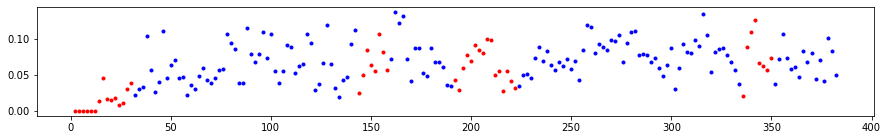

In [62]:
# plot the conditions together with confounding parameters
fig = plt.figure(figsize=(15,2))
for t, f, c in zip(confound_df.timestamps, confound_df.framewise_displacement,colors):
    plt.plot(t, f,'.',c=c)
#plt.xticks(ticks=event_df.onset, labels=event_df.trial_type, rotation=45, ha='right');

In [3]:
all_sub_dicts = []

for sub in subjects:
    # read in the subject's SPM.mat file 
    readmat.load(os.path.join(RESULTS_DIR_6MP,sub,'SPM.mat'),isStruct=True)['SPM']['xX']
    # create a large dataframe for the design matrix and cut out the three conditions of interest
    spm_df = pd.DataFrame(data=np.array(exampl_SPM['X']),columns=exampl_SPM['name'])
    magic_hdr_convolve = spm_df.filter(regex='Magic').sum(axis=1)
    surprise_hdr_convolve = spm_df.filter(regex='Surprise').sum(axis=1)
    control_hdr_convolve = spm_df.filter(regex='Control').sum(axis=1)
    
    # create empty list to store all the frame displacements in
    total_frame_displacement = []
    # get all event files and confound files from the current subject
    eventfiles = glob.glob(os.path.join(RAWDATA_DIR, sub, 'func', '*_events.tsv'))
    realignmentfiles = glob.glob(os.path.join(REALIGNED_DATA, sub, 'func', 'rp_'+sub+'*.txt'))
    
    # sanity check: if number of eventfiles and confoundfiles is not equal -> throw an error
    if len(eventfiles) != len(confoundfiles):
        print('Error: Not the same number of files in {}'.format(sub))
        continue
    # create empty dictionary for the correlations
    sub_dict = {'Magic': [], 'Surprise':[], 'Control':[]}
    
    # cannot iterate over eventfiles and confoundfiles, because fmriprep does no zero leading 
    # events:run-01 confounds:run-1 => sorting results in different order
    for run in range(len(eventfiles)):
        curr_events = os.path.join(RAWDATA_DIR, sub, 'func', sub+'_task-magic_run-{:02}_events.tsv'.format(run+1))
        curr_confounds = os.path.join(FMRIPREP_DIR, sub, 'func', 
        #                              sub+'_task-magic_run-{}_desc-confounds_timeseries.tsv'.format(run+1))
        
        event_df = pd.read_csv(curr_events,sep='\t')
        confound_df = pd.read_csv(curr_confounds,sep='\t')
        # add time to the dataframe by multiplying the index with the TR
        confound_df['timestamps']=confound_df.index*TR
        
        # go through the keys of our sub_dict and add a column for each condition to the confound_df
        for condition in sub_dict.keys():
            condition_events = event_df[event_df.trial_type.str.contains(condition)]
            # create a vector of zeros and change their values to 1 if our condition was present
            confound_df['is_'+condition] = np.zeros((len(confound_df),1))
            for idx,trial in condition_events.iterrows():
                confound_df['is_'+condition] = np.where((confound_df.timestamps>trial.onset) & (confound_df.timestamps<trial.onset+trial.duration),1,confound_df['is_'+condition])
            [corr, p] = stats.spearmanr(confound_df.framewise_displacement,confound_df['is_'+condition], nan_policy='omit')
            sub_dict[condition].append(corr)
    
    all_sub_dicts.append(sub_dict)